# Spam Filter Implementation based on Ruskanda, F.Z., 2019

In this lab, we will replicate the methodology described by Ruskanda (2019) to build a spam filter using machine learning techniques. We will focus on two classifiers: Naive Bayes and Support Vector Machine (SVM). Our goal is to understand the effect of preprocessing and hyperparameter tuning on model performance.


## Initialization

In [1]:
from pandas import DataFrame
import pandas as pd

# Set display options
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)


# Function to get unique values in each column
def get_unique_values(df: DataFrame):
    return {column: set(df[column].unique()) for column in df}

## Load Data

In [2]:
# Load dataset
df = pd.read_csv("sms.csv")

# Display first few rows
df.head()

# Define the appropriate column names
column_names = ["index", "sms", "is_spam", "extra"]

# Load the data into a pandas DataFrame, ignoring the extra column
df = pd.read_csv("sms.csv", names=column_names, usecols=["sms", "is_spam"], skiprows=1)
data = df.copy()

# Display dataset information
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5351 entries, 0 to 5350
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sms      5351 non-null   object
 1   is_spam  5351 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 47.2+ KB
None
                                                 sms  is_spam
0  1. Tension face 2. Smiling face 3. Waste face ...    False
1  Hhahhaahahah rofl was leonardo in your room or...    False
2                        Oh for  sake she's in like     False
3  No da:)he is stupid da..always sending like th...    False
4  Lul im gettin some juicy gossip at the hospita...    False


### Data Cleaning and Preparation

In [3]:
# Convert 'is_spam' from string 'FALSE'/'TRUE' to Boolean values
data["is_spam"] = (
    data["is_spam"]
    .mask(data["is_spam"] == "TRUE", True)
    .mask(data["is_spam"] == "FALSE", False)
)
data = data.convert_dtypes()

# Display data information and first few rows
data.info()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5351 entries, 0 to 5350
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sms      5351 non-null   string 
 1   is_spam  5351 non-null   boolean
dtypes: boolean(1), string(1)
memory usage: 52.4 KB
                                                 sms  is_spam
0  1. Tension face 2. Smiling face 3. Waste face ...    False
1  Hhahhaahahah rofl was leonardo in your room or...    False
2                        Oh for  sake she's in like     False
3  No da:)he is stupid da..always sending like th...    False
4  Lul im gettin some juicy gossip at the hospita...    False


In [4]:
# Check for missing or null values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Reset index
data.reset_index(drop=True, inplace=True)

# Check for duplicate entries
duplicate_rows = data.duplicated()
print("\nDuplicate rows:")
print(duplicate_rows.sum())

# Display distribution of duplicates
print("Marked as spam:", len(data[duplicate_rows][data["is_spam"]]))
print("Marked as not spam:", len(data[duplicate_rows][~data["is_spam"]]))


Missing values per column:
sms        0
is_spam    0
dtype: int64

Duplicate rows:
403
Marked as spam: 102
Marked as not spam: 301


/var/folders/53/5bkhp7ns2pzfq1mljpn8txrw0000gn/T/ipykernel_2124/3432717861.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Marked as spam:", len(data[duplicate_rows][data["is_spam"]]))
/var/folders/53/5bkhp7ns2pzfq1mljpn8txrw0000gn/T/ipykernel_2124/3432717861.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Marked as not spam:", len(data[duplicate_rows][~data["is_spam"]]))


As we can see, only 13% of our sample is marked as spam (704 messages).

In [5]:
# Display cleaned data information and preview
print("\nCleaned data information:")
print(data.info())
print("\nCleaned data preview:")
print(data.head())


Cleaned data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5351 entries, 0 to 5350
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sms      5351 non-null   string 
 1   is_spam  5351 non-null   boolean
dtypes: boolean(1), string(1)
memory usage: 52.4 KB
None

Cleaned data preview:
                                                 sms  is_spam
0  1. Tension face 2. Smiling face 3. Waste face ...    False
1  Hhahhaahahah rofl was leonardo in your room or...    False
2                        Oh for  sake she's in like     False
3  No da:)he is stupid da..always sending like th...    False
4  Lul im gettin some juicy gossip at the hospita...    False


## Pre-Processing

Based on Ruskanda (2019), we will apply the following preprocessing techniques:
- Stemming
- Lemmatization
- Stopwords removal
- Noise removal

In [9]:
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jordan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jordan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jordan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Initialize stemmer, lemmatizer, and stop words
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))


# Function to preprocess text
def preprocess_text(sms):
    sms = re.sub(r"<.*?>", " ", sms)  # Remove HTML tags
    sms = sms.lower()  # Convert to lowercase
    words = word_tokenize(sms)  # Tokenize
    words = [word for word in words if word not in stop_words]  # Remove stop words
    words = [stemmer.stem(word) for word in words]  # Stemming
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    words = [word for word in words if word.isalnum()]  # Remove non-alphanumeric
    return " ".join(words)


# Apply preprocessing
data["sms_cleaned"] = data["sms"].apply(preprocess_text)
print(data[["sms", "sms_cleaned"]].head())

                                                 sms  \
0  1. Tension face 2. Smiling face 3. Waste face ...   
1  Hhahhaahahah rofl was leonardo in your room or...   
2                        Oh for  sake she's in like    
3  No da:)he is stupid da..always sending like th...   
4  Lul im gettin some juicy gossip at the hospita...   

                                         sms_cleaned  
0  tension face smile face wast face innoc face f...  
1             hhahhaahahah rofl leonardo room someth  
2                                       oh sake like  
3                da stupid da alway send like believ  
4             lul im gettin juici gossip hospit oyea  


## Exploratory Data Analysis (EDA)
In this section, we will explore the dataset to understand its characteristics.


Value counts for 'is_spam' column:
is_spam
False    4647
True      704
Name: count, dtype: Int64
is_spam
False    0.868436
True     0.131564
Name: proportion, dtype: Float64


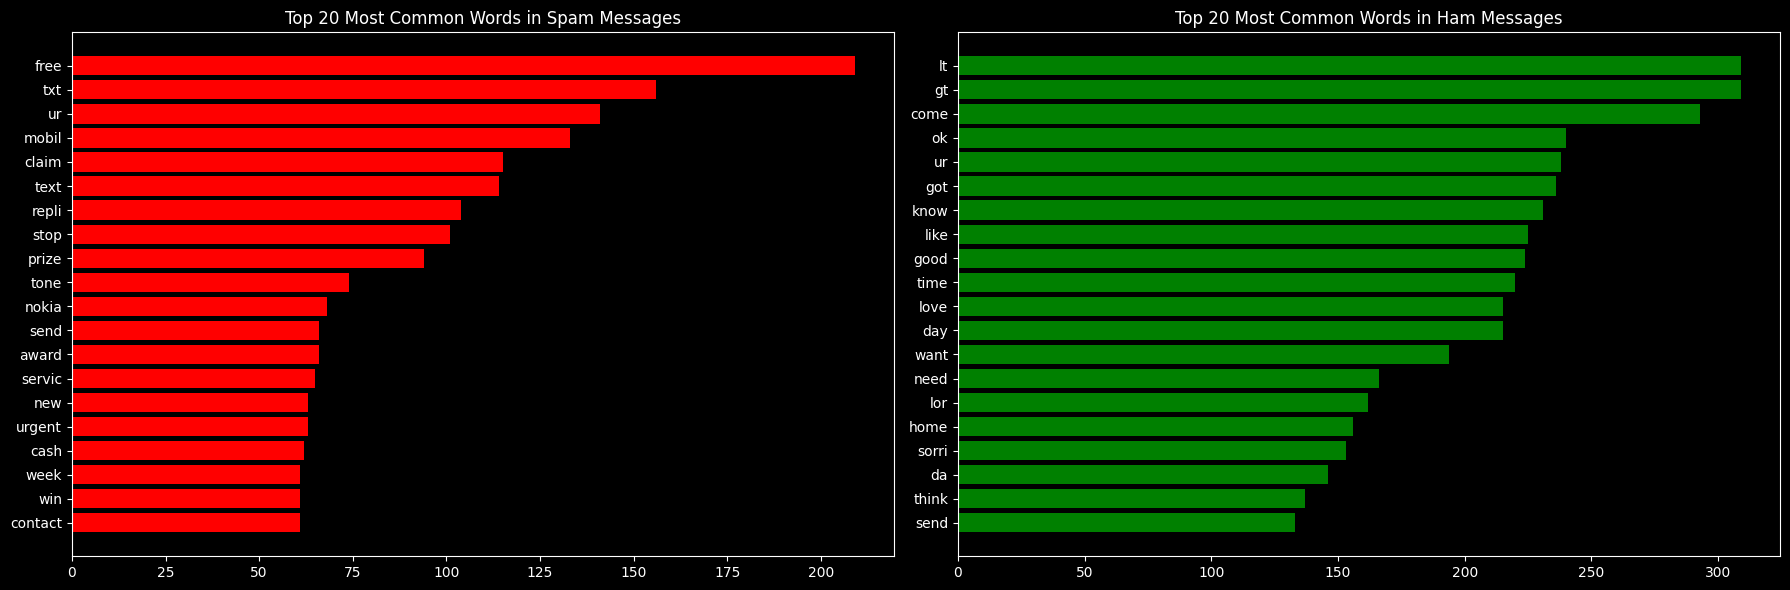

In [11]:
# Value counts for 'is_spam' column
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

print("\nValue counts for 'is_spam' column:")
print(data["is_spam"].value_counts())
print(data["is_spam"].value_counts(normalize=True))


# Function to plot most common words in spam and ham messages
def plot_most_common_words(df, n_top_words=20):
    spam_messages = df[df["is_spam"]]["sms_cleaned"]
    ham_messages = df[~df["is_spam"]]["sms_cleaned"]

    vectorizer_spam = CountVectorizer(stop_words="english")
    vectorizer_ham = CountVectorizer(stop_words="english")

    spam_matrix = vectorizer_spam.fit_transform(spam_messages)
    ham_matrix = vectorizer_ham.fit_transform(ham_messages)

    sum_spam = np.sum(spam_matrix, axis=0)
    sum_ham = np.sum(ham_matrix, axis=0)

    words_spam = [
        (word, sum_spam[0, idx]) for word, idx in vectorizer_spam.vocabulary_.items()
    ]
    words_ham = [
        (word, sum_ham[0, idx]) for word, idx in vectorizer_ham.vocabulary_.items()
    ]

    words_spam = sorted(words_spam, key=lambda x: x[1], reverse=True)[:n_top_words]
    words_ham = sorted(words_ham, key=lambda x: x[1], reverse=True)[:n_top_words]

    spam_words, spam_counts = zip(*words_spam)
    ham_words, ham_counts = zip(*words_ham)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.barh(spam_words, spam_counts, color="red")
    ax1.set_title(f"Top {n_top_words} Most Common Words in Spam Messages")
    ax1.invert_yaxis()

    ax2.barh(ham_words, ham_counts, color="green")
    ax2.set_title(f"Top {n_top_words} Most Common Words in Ham Messages")
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()


# Plot most common words
plot_most_common_words(data, n_top_words=20)

## Data Splitting
We will split the data into training and testing sets, and apply oversampling using SMOTE to handle class imbalance.

In [12]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

# Extract features using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["sms_cleaned"])

# Define target variable 'y'
y = df["is_spam"].astype(int)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize and fit SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Display class distribution after SMOTE
print("Class distribution in y_train_smote:", pd.Series(y_train_smote).value_counts())

Class distribution in y_train_smote: is_spam
0    3252
1    3252
Name: count, dtype: int64


## Model Training: Naive Bayes Classifier

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred = nb_classifier.predict(X_test)

# Accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Naive Bayes classifier: {accuracy:.2f}")
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=["Ham", "Spam"])
print("Classification Report:\n", class_report)

Accuracy of the Naive Bayes classifier: 0.96
Confusion Matrix:
 [[1347   48]
 [  19  192]]
Classification Report:
               precision    recall  f1-score   support

         Ham       0.99      0.97      0.98      1395
        Spam       0.80      0.91      0.85       211

    accuracy                           0.96      1606
   macro avg       0.89      0.94      0.91      1606
weighted avg       0.96      0.96      0.96      1606



As Ruskanda (2019) suggests, accuracy alone is not sufficient to evaluate model performance, especially with imbalanced datasets. Instead, precision, recall, and F1-score provide a more comprehensive view.

## Model Training: Support Vector Machine (SVM)

In [14]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create SVM pipeline
svm_pipeline = make_pipeline(
    StandardScaler(with_mean=False), SVC(kernel="linear", random_state=42)
)

# Train SVM model
svm_pipeline.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_svm = svm_pipeline.predict(X_test)

# Accuracy and confusion matrix
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy of the SVM classifier: {accuracy_svm:.2f}")
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:\n", conf_matrix_svm)

# Classification report
class_report_svm = classification_report(
    y_test, y_pred_svm, target_names=["Ham", "Spam"]
)
print("Classification Report:\n", class_report_svm)

Accuracy of the SVM classifier: 0.85
Confusion Matrix:
 [[1201  194]
 [  43  168]]
Classification Report:
               precision    recall  f1-score   support

         Ham       0.97      0.86      0.91      1395
        Spam       0.46      0.80      0.59       211

    accuracy                           0.85      1606
   macro avg       0.71      0.83      0.75      1606
weighted avg       0.90      0.85      0.87      1606



Let's record the initial performance of the SVM:

    Accuracy of the SVM classifier: 0.85
    Confusion Matrix:
    [[1200  195]
    [  43  168]]
    Classification Report:
                  precision    recall  f1-score   support

            Ham       0.97      0.86      0.91      1395
            Spam       0.46      0.80      0.59       211

        accuracy                            0.85      1606
      macro avg       0.71      0.83      0.75      1606
    weighted avg      0.90      0.85      0.87      1606


## Hyperparameter Optimization — Grid Search
We will use GridSearchCV to find the best hyperparameters for both the Naive Bayes and SVM classifiers.

In [15]:
from sklearn.model_selection import GridSearchCV

# Naive Bayes parameters
params_nb = {"alpha": [0.01, 0.1, 0.5, 1.0, 10.0]}
nb_grid_search = GridSearchCV(
    nb_classifier, param_grid=params_nb, cv=5, scoring="f1_weighted"
)
nb_grid_search.fit(X_train_smote, y_train_smote)

print("Best Naive Bayes Parameters:", nb_grid_search.best_params_)
print("Best Naive Bayes Model:", nb_grid_search.best_estimator_)
print("Best CV Score:", nb_grid_search.best_score_)

# SVM parameters
params_svm = {
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", "auto"],
    "svc__kernel": ["linear", "rbf"],
}
svm_grid_search = GridSearchCV(
    svm_pipeline, param_grid=params_svm, cv=5, scoring="f1_weighted", n_jobs=1
)
svm_grid_search.fit(X_train_smote, y_train_smote)

print("Best SVM Parameters:", svm_grid_search.best_params_)
print("Best SVM Model:", svm_grid_search.best_estimator_)
print("Best CV Score:", svm_grid_search.best_score_)

Best Naive Bayes Parameters: {'alpha': 0.1}
Best Naive Bayes Model: MultinomialNB(alpha=0.1)
Best CV Score: 0.8664429432234687
Best SVM Parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best SVM Model: Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=10, random_state=42))])
Best CV Score: 0.9296629678849218


## Train and Evaluate Best Models

### Best Model SVC

In [16]:
# Create best SVM pipeline with optimal hyperparameters
best_svm_pipeline = make_pipeline(
    StandardScaler(with_mean=False),
    SVC(C=10, kernel="rbf", gamma="scale", random_state=42),
)

# Train the SVM model with optimal hyperparameters
best_svm_pipeline.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_svm = best_svm_pipeline.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy of the SVM classifier: {accuracy_svm:.2f}")

# Generate confusion matrix and classification report
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:\n", conf_matrix_svm)
class_report_svm = classification_report(
    y_test, y_pred_svm, target_names=["Ham", "Spam"]
)
print("Classification Report:\n", class_report_svm)

Accuracy of the SVM classifier: 0.87
Confusion Matrix:
 [[1265  130]
 [  80  131]]
Classification Report:
               precision    recall  f1-score   support

         Ham       0.94      0.91      0.92      1395
        Spam       0.50      0.62      0.56       211

    accuracy                           0.87      1606
   macro avg       0.72      0.76      0.74      1606
weighted avg       0.88      0.87      0.87      1606



### Best Model Naive Bayes

In [17]:
# Train Naive Bayes classifier with optimal hyperparameters
best_nb_classifier = MultinomialNB(alpha=0.1)
best_nb_classifier.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_nb = best_nb_classifier.predict(X_test)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy of the Naive Bayes classifier: {accuracy_nb:.2f}")

# Generate confusion matrix and classification report
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print("Confusion Matrix:\n", conf_matrix_nb)
class_report_nb = classification_report(y_test, y_pred_nb, target_names=["Ham", "Spam"])
print("Classification Report:\n", class_report_nb)

Accuracy of the Naive Bayes classifier: 0.97
Confusion Matrix:
 [[1357   38]
 [  18  193]]
Classification Report:
               precision    recall  f1-score   support

         Ham       0.99      0.97      0.98      1395
        Spam       0.84      0.91      0.87       211

    accuracy                           0.97      1606
   macro avg       0.91      0.94      0.93      1606
weighted avg       0.97      0.97      0.97      1606



The results show that Naive Bayes outperforms SVM in terms of precision, recall, and F1-score. However, both models benefit from hyperparameter tuning.

## Testing Model Performance
We will measure the training and prediction times, as well as accuracy and balanced accuracy for both models.

In [18]:
import time
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Initialize dictionaries to save the evaluation metrics
metrics_nb = {}
metrics_svc = {}

# Evaluate Naive Bayes
start_train_nb = time.time()
best_nb_classifier.fit(X_train_smote, y_train_smote)
end_train_nb = time.time()
metrics_nb["training_time"] = end_train_nb - start_train_nb

start_pred_nb = time.time()
y_pred_nb = best_nb_classifier.predict(X_test)
end_pred_nb = time.time()
metrics_nb["prediction_time"] = end_pred_nb - start_pred_nb
metrics_nb["accuracy"] = accuracy_score(y_test, y_pred_nb)
metrics_nb["balanced_accuracy"] = balanced_accuracy_score(y_test, y_pred_nb)

# Print Naive Bayes metrics
print("Naive Bayes Metrics:")
for metric, value in metrics_nb.items():
    print(f"{metric}: {value:.4f}")

# Evaluate SVM
start_train_svc = time.time()
best_svm_pipeline.fit(X_train_smote, y_train_smote)
end_train_svc = time.time()
metrics_svc["training_time"] = end_train_svc - start_train_svc

start_pred_svc = time.time()
y_pred_svc = best_svm_pipeline.predict(X_test)
end_pred_svc = time.time()
metrics_svc["prediction_time"] = end_pred_svc - start_pred_svc
metrics_svc["accuracy"] = accuracy_score(y_test, y_pred_svc)
metrics_svc["balanced_accuracy"] = balanced_accuracy_score(y_test, y_pred_svc)

# Print SVM metrics
print("\nSVM Metrics:")
for metric, value in metrics_svc.items():
    print(f"{metric}: {value:.4f}")

Naive Bayes Metrics:
training_time: 0.0068
prediction_time: 0.0007
accuracy: 0.9651
balanced_accuracy: 0.9437

SVM Metrics:
training_time: 1.3312
prediction_time: 0.2263
accuracy: 0.8692
balanced_accuracy: 0.7638


## Discussion
Reflect on the results and performance of both models.

- Which model performed better overall?
- What could be the reasons for the difference in performance?
- How did hyperparameter tuning affect the model outcomes?
- Are there any additional techniques or preprocessing steps you think could improve the results?

## References

Kaddoura, S., Chandrasekaran, G., Popescu, D.E. and Duraisamy, J.H., 2022. A systematic literature review on spam content detection and classification. _PeerJ Computer Science_, 8:e830. Available at: <https://doi.org/10.7717/peerj-cs.830>

Ruskanda, F.Z., 2019. Study on the effect of preprocessing methods for spam email detection. _Indonesia Journal of Computing_, 4(1), MARET. Available at: <https://doi.org/10.21108/INDOJC.2019.4.1.284>
